In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans

In [2]:
import matplotlib.pyplot as plt
import squarify
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO

In [3]:
#reading data and checking null values
df= pd.read_csv('pranav_dataset.csv',sep='|')

df.isnull().sum()

cont_id             2
transaction_id      2
transaction_date    2
prod_price_net      2
prod_id             3
dtype: int64

In [4]:
df.isnull().any(axis=1)
df[df.isnull().any(axis=1)]

cont_id     transaction_id transaction_date  prod_price_net prod_id
512     6935  4064 FARMBALE AVE  STUDIO CITY, CA             0.0     NaN
1832     NaN                NaN              NaN             NaN     NaN
1833     NaN                NaN              NaN             NaN     NaN

In [5]:
#As the null values are less, drop the null rows. 
df.dropna(inplace=True)
df.head()


cont_id transaction_id transaction_date  prod_price_net    prod_id
0  100504335      100503936       10/11/2019         67023.0  100059589
1  100406909      100402572        3/30/2017          1101.0  101101914
2  100006079      100007232        5/21/2013          8530.0  100055307
3  100202212      100202600        4/28/2018           470.0  101101914
4  100013023      100019059        3/19/2019         20844.0  790199694

In [6]:
#checking the data type of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cont_id           9997 non-null   object 
 1   transaction_id    9997 non-null   object 
 2   transaction_date  9997 non-null   object 
 3   prod_price_net    9997 non-null   float64
 4   prod_id           9997 non-null   object 
dtypes: float64(1), object(4)
memory usage: 468.6+ KB


In [7]:
#Change the data type of columns.
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df["cont_id"]=pd.to_numeric(df["cont_id"],downcast ='signed', errors='coerce')
df["transaction_id"]=pd.to_numeric(df["transaction_id"],downcast ='signed', errors='coerce')
df["prod_price_net"]=pd.to_numeric(df["prod_price_net"], errors='coerce')
df["prod_id"]=pd.to_numeric(df["prod_id"],downcast ='signed', errors='coerce')



In [8]:
#null values check
df.isnull().sum()

cont_id             1
transaction_id      0
transaction_date    1
prod_price_net      0
prod_id             1
dtype: int64

In [9]:
df.isnull().any(axis=1)
df[df.isnull().any(axis=1)]

cont_id  transaction_id transaction_date  prod_price_net  prod_id
1834      NaN        13865.23              NaT             0.0      NaN

In [10]:
#As there is only 1 row with null values in it, drop that row.
df.dropna(inplace=True)
df.head()

cont_id  transaction_id transaction_date  prod_price_net      prod_id
0  100504335.0     100503936.0       2019-10-11         67023.0  100059589.0
1  100406909.0     100402572.0       2017-03-30          1101.0  101101914.0
2  100006079.0     100007232.0       2013-05-21          8530.0  100055307.0
3  100202212.0     100202600.0       2018-04-28           470.0  101101914.0
4  100013023.0     100019059.0       2019-03-19         20844.0  790199694.0

In [11]:
#as customer id, transaction id, product id can't be float.
df['cont_id']=df['cont_id'].astype(int)
df['transaction_id']=df['transaction_id'].astype(int)
df['prod_id']=df['prod_id'].astype(int)



In [12]:
df.isnull().sum()

cont_id             0
transaction_id      0
transaction_date    0
prod_price_net      0
prod_id             0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9996 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cont_id           9996 non-null   int32         
 1   transaction_id    9996 non-null   int32         
 2   transaction_date  9996 non-null   datetime64[ns]
 3   prod_price_net    9996 non-null   float64       
 4   prod_id           9996 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3)
memory usage: 351.4 KB


In [14]:
df.describe()

cont_id  transaction_id  prod_price_net       prod_id
count  9.996000e+03    9.996000e+03     9996.000000  9.996000e+03
mean   1.006836e+08    1.006961e+08    22085.000900  5.230189e+08
std    7.731051e+05    7.855647e+05    34859.704859  3.390072e+08
min    1.000000e+08    1.000000e+08    -3082.000000  1.000520e+08
25%    1.000121e+08    1.000152e+08     4744.500000  1.011019e+08
50%    1.004063e+08    1.004023e+08    11905.000000  7.900539e+08
75%    1.015003e+08    1.015006e+08    25542.750000  7.901750e+08
max    1.028003e+08    1.028003e+08   696720.000000  9.000823e+08

In [15]:
#identifing earliest and latest dates of transaction. 
print(df['transaction_date'].min(), df['transaction_date'].max())

2006-05-26 00:00:00 2019-10-23 00:00:00


In [16]:
#calculating no. days for each purchase
sd = df['transaction_date'].max() + datetime.timedelta(days=1)
df['hist']=sd - df['transaction_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')


In [17]:
#creating group according to customer_id, and calculating recency, frequency,and monetary values.
rfmTable = df.groupby('cont_id').agg({'hist': lambda x:x.min(), # Recency
                                        'cont_id': lambda x: len(x), # Frequency
                                        'prod_price_net': lambda x: x.sum()}) # Monetary Value

rfmTable.rename(columns={'hist': 'recency', 
                         'cont_id': 'frequency', 
                         'prod_price_net': 'monetary_value'}, inplace=True)

In [18]:
rfmTable.shape

(6506, 3)

In [19]:
rfmTable.head()

recency  frequency  monetary_value
cont_id                                      
100000005   4899.0          1         18046.0
100000038   4427.0          1          5610.0
100000041   4827.0          2         20294.0
100000048   4857.0          1          8870.0
100000064   3451.0          1          2935.0

In [20]:
#creating 4 categories according to the quartile values.
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25    546.0        1.0          5470.5
0.50   1246.5        1.0         12998.5
0.75   2187.0        2.0         29355.0 <class 'pandas.core.frame.DataFrame'>


In [21]:
quartiles=quartiles.to_dict()
quartiles

{'recency': {0.25: 546.0, 0.5: 1246.5, 0.75: 2187.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'monetary_value': {0.25: 5470.5, 0.5: 12998.5, 0.75: 29355.0}}

In [22]:
#function for recency 1 being the best value.
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value, 1 being the best value. 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [23]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [24]:
#method1: concatinate the r,f,m scores. As the unique values are more 
#it is not easy to understand. 
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [25]:
rfmSeg.head()

recency  frequency  monetary_value  R_Quartile  F_Quartile  \
cont_id                                                                 
100000005   4899.0          1         18046.0           4           4   
100000038   4427.0          1          5610.0           4           4   
100000041   4827.0          2         20294.0           4           2   
100000048   4857.0          1          8870.0           4           4   
100000064   3451.0          1          2935.0           4           4   

           M_Quartile RFMClass  
cont_id                         
100000005           2      442  
100000038           3      443  
100000041           2      422  
100000048           3      443  
100000064           4      444

In [26]:
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

recency  frequency  monetary_value  R_Quartile  F_Quartile  \
cont_id                                                                 
100014783    363.0          9       2372665.0           1           1   
101501799    138.0          7       1588405.0           1           1   
102500557    101.0          7       1287533.0           1           1   
101502398    343.0          9       1051025.0           1           1   
100101794    347.0          7       1019833.0           1           1   
...            ...        ...             ...         ...         ...   
101500249   2594.0          1             0.0           4           4   
101600052   2257.0          1             0.0           4           4   
101700075   2280.0          1             0.0           4           4   
101700080   2276.0          1             0.0           4           4   
101700212   2283.0          1             0.0           4           4   

           M_Quartile RFMClass  
cont_id                         
100014783           1      111  
101501799           1      111  
102500557           1      111  
101502398           1      111  
100101794           1      111  
...               ...      ...  
101500249           4      444  
101600052           4      444  
101700075           4      444  
101700080           4      444  
101700212           4      444  

[6506 rows x 7 columns]

In [27]:
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()

RFMClass
111    185397.723404
112     20812.763158
113      9432.750000
114      1326.625000
121     66382.320000
122     21070.553398
123      8827.872340
124      2312.322581
141     48136.864407
142     18944.550000
143      9031.435540
144      1933.177546
211    195130.775862
212     21959.130435
213     10876.142857
214      2000.000000
221     63319.750000
222     20295.395349
223      9099.600000
224      2391.393939
241     50948.486239
242     18961.018382
243      8874.519174
244      2228.268041
311    164587.380952
312     20177.764706
313     10476.000000
314      1202.750000
321     77253.155039
322     20140.300000
323      9657.724138
324      1548.833333
341     48968.843478
342     19290.079208
343      9234.812169
344      2117.351282
411    155431.928571
412     21709.375000
413      9635.666667
414      1344.000000
421     72584.704000
422     20892.380282
423     10027.172414
424      2444.166667
441     49285.179688
442     19128.358090
443      9042.410596
444 

In [28]:
#Method2: Add the R,F,M scores. As there are only 12 unique values,
#its easy to understand.
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6506 entries, 100000005 to 102800319
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6506 non-null   float64
 1   frequency       6506 non-null   int32  
 2   monetary_value  6506 non-null   float64
 3   R_Quartile      6506 non-null   int64  
 4   F_Quartile      6506 non-null   int64  
 5   M_Quartile      6506 non-null   int64  
 6   RFMClass        6506 non-null   object 
 7   Total Score     6506 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(1)
memory usage: 432.0+ KB
           recency  frequency  monetary_value  R_Quartile  F_Quartile  \
cont_id                                                                 
100000005   4899.0          1         18046.0           4           4   
100000038   4427.0          1          5610.0           4           4   
100000041   4827.0          2         20294.0           4        

In [29]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean()

Total Score
3     185397.723404
4     123483.392265
5      80539.514706
6      60406.896266
7      33409.404321
8      18657.352078
9      13369.177778
10     10039.868398
11      5838.646501
12      2480.541176
Name: monetary_value, dtype: float64

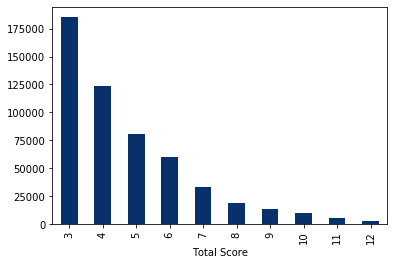

In [36]:
#customers with total score of 3,4,5 adds upto maximum monetary_value.
fig=rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r').get_figure()
fig
fig.savefig('C:/Users/12014/Documents/tot_mon')

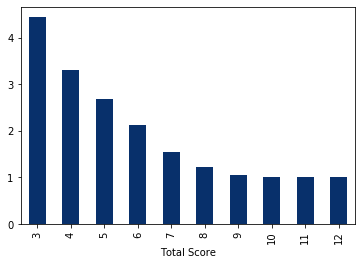

In [237]:
#customers with total score of 3,4,5 are more frequent in pruchasing.
fig1=rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r').get_figure()
fig1
fig1.savefig('C:/Users/12014/Documents/tot_frq')

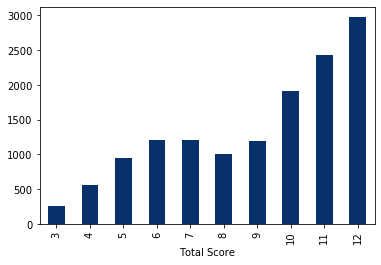

In [238]:
#the most recent customers are with the total scores of 3,4,5
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')

In [239]:
#stimulating the response of customer to promotions.
col=['R_Quartile','F_Quartile','M_Quartile']
features=rfmSeg[['R_Quartile','F_Quartile','M_Quartile']].values


In [240]:
matrix = features

km = KMeans(n_clusters = 2, n_init=2)
km.fit(matrix)
labels = km.labels_

rfmSeg['response'] = labels
print(rfmSeg.head())
rfmSeg.shape


           recency  frequency  monetary_value  R_Quartile  F_Quartile  \
cont_id                                                                 
100000005   4899.0          1         18046.0           4           4   
100000038   4427.0          1          5610.0           4           4   
100000041   4827.0          2         20294.0           4           2   
100000048   4857.0          1          8870.0           4           4   
100000064   3451.0          1          2935.0           4           4   

           M_Quartile RFMClass  Total Score  response  
cont_id                                                
100000005           2      442           10         0  
100000038           3      443           11         0  
100000041           2      422            8         1  
100000048           3      443           11         0  
100000064           4      444           12         0  


(6506, 9)

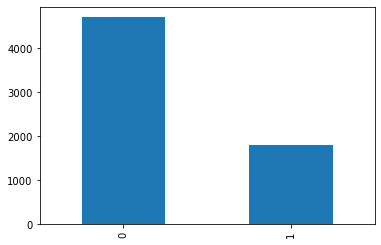

In [241]:
pd.value_counts(rfmSeg['response']).plot.bar()

In [242]:
rfmSeg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6506 entries, 100000005 to 102800319
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6506 non-null   float64
 1   frequency       6506 non-null   int32  
 2   monetary_value  6506 non-null   float64
 3   R_Quartile      6506 non-null   int64  
 4   F_Quartile      6506 non-null   int64  
 5   M_Quartile      6506 non-null   int64  
 6   RFMClass        6506 non-null   object 
 7   Total Score     6506 non-null   int64  
 8   response        6506 non-null   int32  
dtypes: float64(2), int32(2), int64(4), object(1)
memory usage: 457.5+ KB


Text(0, 0.5, 'Proportion of Responders')

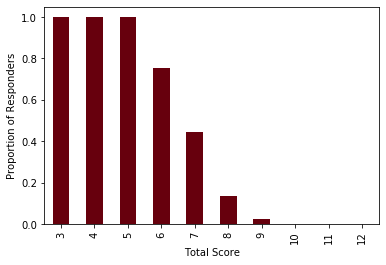

In [243]:
#customers with scores 3,4,5 are most likely to respond to the promotions.
ax=rfmSeg.groupby('Total Score').agg('response').mean().plot(kind='bar', colormap='Reds_r')
ax.set_xlabel("Total Score")
ax.set_ylabel("Proportion of Responders")


In [244]:
# Define rfm_level function
def rfm_level(df):
    if df['Total Score'] >= 9:
        return 'Require Activation'
    elif ((df['Total Score'] >= 8) and (df['Total Score'] < 9)):
        return 'Needs Attention'
    elif ((df['Total Score'] >= 7) and (df['Total Score'] < 8)):
        return 'Promising'
    elif ((df['Total Score'] >= 6) and (df['Total Score'] < 7)):
        return 'Potential'
    elif ((df['Total Score'] >= 5) and (df['Total Score'] < 6)):
        return 'Loyal'
    elif ((df['Total Score'] >= 4) and (df['Total Score'] < 5)):
        return 'Champions'
    else:
        return 'Can\'t Loose Them'
# Create a new variable RFM_Level
rfmSeg['RFM_Level'] = rfmSeg.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfmSeg.head()

recency  frequency  monetary_value  R_Quartile  F_Quartile  \
cont_id                                                                 
100000005   4899.0          1         18046.0           4           4   
100000038   4427.0          1          5610.0           4           4   
100000041   4827.0          2         20294.0           4           2   
100000048   4857.0          1          8870.0           4           4   
100000064   3451.0          1          2935.0           4           4   

           M_Quartile RFMClass  Total Score  response           RFM_Level  
cont_id                                                                    
100000005           2      442           10         0  Require Activation  
100000038           3      443           11         0  Require Activation  
100000041           2      422            8         1     Needs Attention  
100000048           3      443           11         0  Require Activation  
100000064           4      444           12         0  Require Activation

In [251]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfmSeg.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   recency frequency monetary_value      
                      mean      mean           mean count
RFM_Level                                                
Can't Loose Them     263.8       4.4       185397.7   235
Champions            559.1       3.3       123483.4   362
Loyal                951.1       2.7        80539.5   408
Needs Attention     1010.8       1.2        18657.4   818
Potential           1207.2       2.1        60406.9   482
Promising           1210.1       1.6        33409.4   648
Require Activation  1891.0       1.0         9458.2  3553


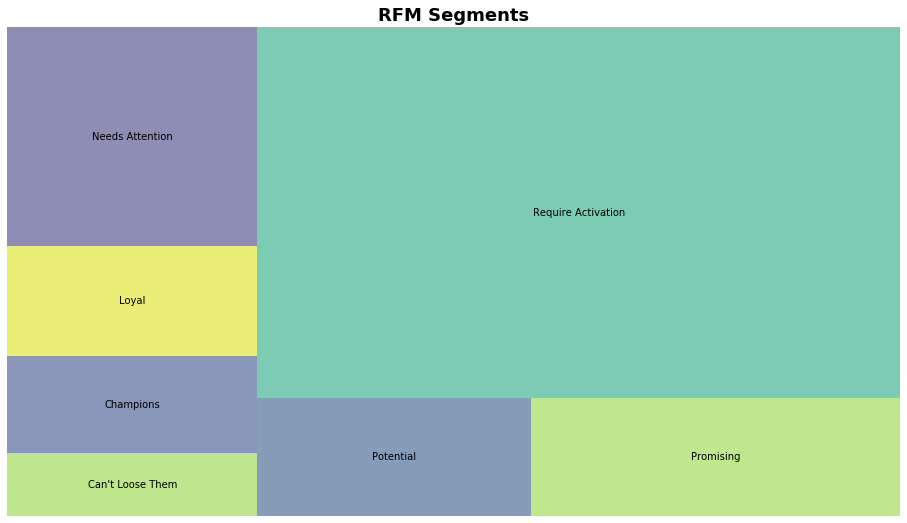

In [252]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()
